# Construction of sparse basis via Leaf Removal
-----------------
**Idea**: given a parity-check matrix $H\in\mathbb{GF}(2)^{m,n}$ and its corresponding factor graph,
- Use Leaf Removal to separate variables into a set of $m$ dependent and $n-m$ independent ones $$H = [T|M]$$
- Build a basis by setting, for each basis vector $\underline{v}^{(i)}$:
    - For the independent variables, put a $1$ in position $i$ and all the rest zeros $$v_{indep}^{(i)}=\mathbb{1}_{i}\quad$$
    - Fix the dependent variables (uniquely determined from the independent part)
<!--     $$\underline{v}_{dep}^{(i)}=f\left(\{\underline{v}_{indep}^{(i)}\}\right)$$ -->
        $$\underline{v}_{dep} = T^{-1}M$$
    
**Goal**: Is this basis sparse? What is the maximum Hamming weight between all basis vectors?

## 1. Check that the built basis actually solves the system

In [46]:
include("../code/headers.jl");

Build a random graph (with leaves!)

In [7]:
seed = abs(rand(Int))
const q = 2
n = 20
m = 15
fg = ldpc_graph(q, n, m, randseed=seed)
breduction!(fg);

Compute the basis

In [8]:
nb = newbasis(fg)

20×6 Array{Int64,2}:
 0  1  0  0  0  0
 0  1  0  1  0  0
 0  0  1  1  0  0
 0  0  1  1  1  1
 1  0  0  0  0  0
 0  1  0  0  0  0
 0  0  1  1  0  0
 0  0  0  0  1  1
 1  0  0  0  1  1
 0  0  0  1  0  0
 0  0  0  1  0  0
 0  0  0  0  1  1
 0  0  1  0  0  0
 0  0  0  1  0  0
 1  0  0  0  1  1
 0  0  1  0  0  1
 0  0  0  0  1  0
 0  0  0  0  0  1
 0  0  0  0  1  1
 0  0  0  1  1  0

Check that parity is satisfied by all of the basis vectors

In [9]:
parity(fg, nb)

0

## 2. Build large instances and observe sparsity

In [19]:
function avg_hw(A::Array{Int,2})
    (n,k) = size(A)
    hws = [hw(A[:,c]) for c in 1:k]
    return mean(hws)
end
function max_hw(A::Array{Int,2})
    (n,k) = size(A)
    hws = [hw(A[:,c]) for c in 1:k]
    return maximum(hws)
end
function hws(q, n, m, seed, b=1)
    fg = ldpc_graph(q,n,m+b, randseed=seed)
    breduction!(fg, randseed=seed, b)
    nb = newbasis(fg)
    return max_hw(nb), avg_hw(nb)
end

hws (generic function with 2 methods)

In [20]:
ngraphs = 20
nn = 2 .^ (4:12)
nsizes = length(nn)
R = 0.3
max_hws = zeros(nsizes, ngraphs)
avg_hws = zeros(nsizes, ngraphs);

In [ ]:
for (i,n) in enumerate(nn)
    println("n=$n. Size $i of $nsizes")
    m = Int(round(n*(1-R)))
    @showprogress for g in 1:ngraphs
        max_hws[i,g], avg_hws[i,g] = hws(q, n, m, seed+g)
    end
end

### Plot as n increases

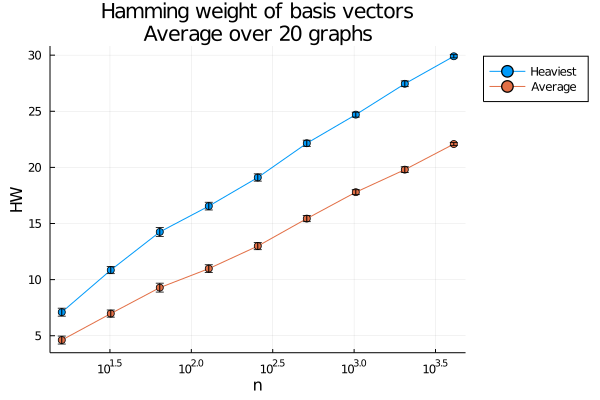

In [31]:
avg_max_hw = mean(max_hws, dims=2)
sd_max_hw = std(max_hws, dims=2) / sqrt(ngraphs)
avg_avg_hw = mean(avg_hws, dims=2)
sd_avg_hw = std(max_hws, dims=2) / sqrt(ngraphs)
pl = Plots.plot(nn, avg_max_hw, yerr=sd_max_hw, marker=:circle, label="Heaviest", xscale=:log10)
Plots.plot!(pl, nn, avg_avg_hw, yerr=sd_avg_hw, marker=:circle, label="Average", xscale=:log10, legend=:outertopright)
Plots.xlabel!("n"); Plots.ylabel!("HW"); 
Plots.title!("Hamming weight of basis vectors\nAverage over $(size(max_hws,2)) graphs")

## 3.1. b increases linearly with n

I'm performing $b$-reduction to expose leaves. In the previous, we had a fixed $b=1$ for all values of $n$.

In the following, the number $b$ of removed factors scales linearly with $n$:
$$b=\frac{n}{100}.$$

In [ ]:
ngraphs = 20
nn = 2 .^ (4:12)
nsizes = length(nn)
R = 0.3
b = ceil.(Int, nn ./ 100)
max_hws_new = zeros(nsizes, ngraphs)
avg_hws_new = zeros(nsizes, ngraphs)

for (i,n) in enumerate(nn)
    println("n=$n. Size $i of $nsizes")
    m = Int(round(n*(1-R)))
    @showprogress for g in 1:ngraphs
        max_hws_new[i,g], avg_hws_new[i,g] = hws(q, n, m, seed+g, b[i])
    end
end

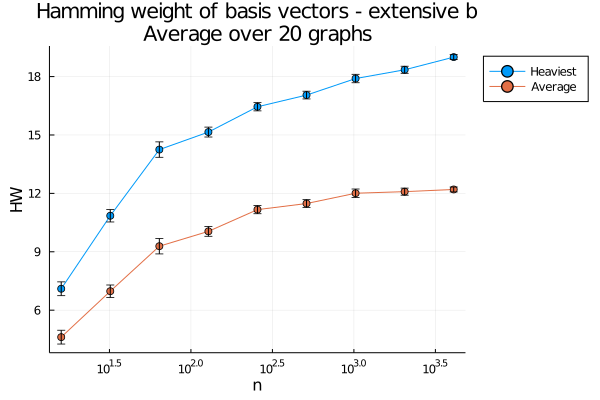

In [33]:
avg_max_hw_new = mean(max_hws_new, dims=2)
sd_max_hw_new = std(max_hws_new, dims=2) / sqrt(ngraphs)
avg_avg_hw_new = mean(avg_hws_new, dims=2)
sd_avg_hw_new = std(max_hws_new, dims=2) / sqrt(ngraphs)
pl = Plots.plot(nn, avg_max_hw_new, yerr=sd_max_hw_new, marker=:circle, label="Heaviest", xscale=:log10)
Plots.plot!(pl, nn, avg_avg_hw_new, yerr=sd_avg_hw_new, marker=:circle, label="Average", xscale=:log10, 
    legend=:outertopright)
Plots.xlabel!("n"); Plots.ylabel!("HW"); 
Plots.title!("Hamming weight of basis vectors - extensive b\nAverage over $(size(max_hws,2)) graphs")

# 3. Rate-distortion plane

Compare compression performances between $b=1$ and $b=\frac{n}{100}$

In [66]:
gamma = 5e-3
n = Int(round(420*4/log2(q)))
R = collect(0.21:0.1:0.81) 
m = Int.(round.(n*(1 .- R)))
b = Int(round(n/100))*ones(Int, length(m))
maxiter = Int(5e1)
niter = 10
randseed = 1234
Tmax = 1;

In [ ]:
algo = MS(maxiter=maxiter, gamma=gamma, Tmax=Tmax, default_distortion=fix_indep_from_ms)
sims_b1 = Vector{Simulation{MS}}(undef, length(m))
sims_b100 = Vector{Simulation{MS}}(undef, length(m))
niter = 10

for j in 1:length(m)
    println("\n---------- Simulation $j of ", length(m)," | R = ",R[j]," -----------")
    sims_b1[j] = Simulation(q, n, m[j], algo, niter=niter, b=1, randseed=randseed, showprogress=true)
    sims_b100[j] = Simulation(q, n, m[j], algo, niter=niter, b=b[j], randseed=randseed, showprogress=true)
end

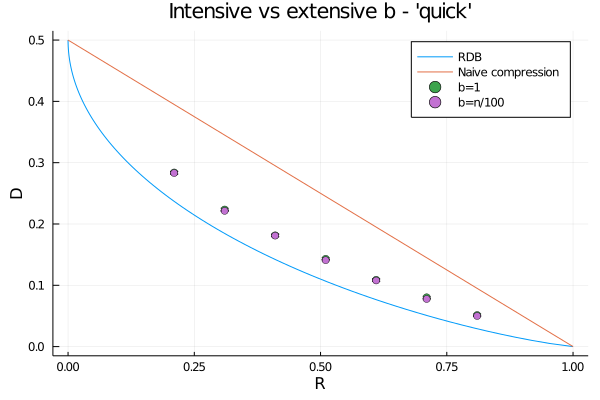

In [72]:
plt = plot(sims_b1, label="b=1")
plot!(plt, sims_b100, label="b=n/100")
title!("Intensive vs extensive b - 'quick'")

In [73]:
gamma = 5e-3
n = Int(round(420*4/log2(q)))
R = collect(0.21:0.1:0.81) 
m = Int.(round.(n*(1 .- R)))
b = Int(round(n/100))*ones(Int, length(m))
maxiter = Int(3e2)
niter = 10
randseed = 1234
Tmax = 5;

In [ ]:
algo = MS(maxiter=maxiter, gamma=gamma, Tmax=Tmax, default_distortion=fix_indep_from_ms)
sims_b1 = Vector{Simulation{MS}}(undef, length(m))
sims_b100 = Vector{Simulation{MS}}(undef, length(m))
niter = 10

for j in 1:length(m)
    println("\n---------- Simulation $j of ", length(m)," | R = ",R[j]," -----------")
    sims_b1[j] = Simulation(q, n, m[j], algo, niter=niter, b=1, randseed=randseed, showprogress=true)
    sims_b100[j] = Simulation(q, n, m[j], algo, niter=niter, b=b[j], randseed=randseed, showprogress=true)
end

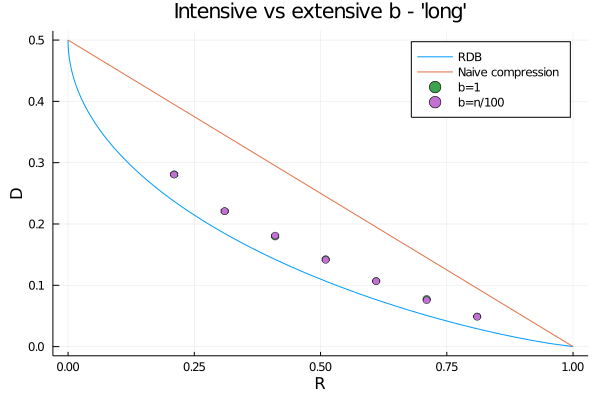

In [76]:
plt = plot(sims_b1, label="b=1")
plot!(plt, sims_b100, label="b=n/100")
title!("Intensive vs extensive b - 'long'")

## 4. Computational time

In [15]:
using BenchmarkTools
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 30
include("../code/headers.jl");

In [16]:
nn = 100:100:2000
nsizes = length(nn)
R = 0.3
runtimes = zeros(nsizes)
println("-- This will take approx $(BenchmarkTools.DEFAULT_PARAMETERS.seconds*nsizes) seconds")
for (i,n) in enumerate(nn)
    println("n=$n. Size $i of $nsizes")
    m = Int(round(n*(1-R)))
    fg =ldpc_graph(q,n,m, randseed=seed+i)
    breduction!(fg, randseed=seed)
    H,c = permute_to_triangular(fg)
    runtimes[i] = @belapsed newbasis($H, $c)
end

-- This will take approx 600.0 seconds
n=100. Size 1 of 20
n=400. Size 4 of 20
n=500. Size 5 of 20
n=600. Size 6 of 20
n=700. Size 7 of 20
n=800. Size 8 of 20
n=900. Size 9 of 20
n=1000. Size 10 of 20
n=1100. Size 11 of 20
n=1200. Size 12 of 20
n=1300. Size 13 of 20
n=1400. Size 14 of 20
n=1500. Size 15 of 20
n=1600. Size 16 of 20
n=1700. Size 17 of 20
n=1800. Size 18 of 20
n=1900. Size 19 of 20
n=2000. Size 20 of 20


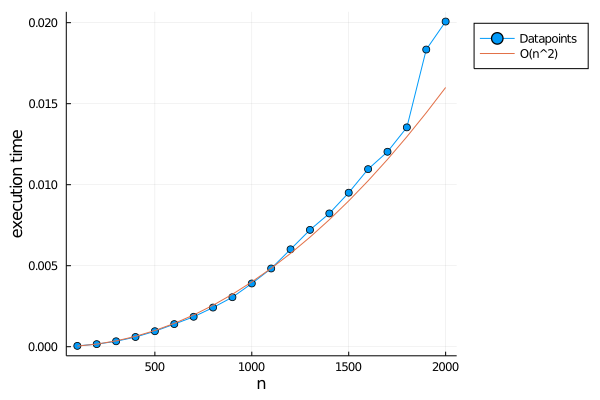

In [17]:
plot(nn, runtimes, xlabel="n", ylabel="execution time", marker=:circle, label="Datapoints", legend = :outertopright)
k = 2
plot!(nn, nn.^k .* 4e-9, label="O(n^$k)")